In [ ]:

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import SimpleRNN, GRU,LSTM, Dense, Dropout,Bidirectional # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
!pip install yfinance
import yfinance as yf #Alternative package if webreader does not work: pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 9.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))



Tensorflow Version: 2.9.2
Num GPUs: 1


In [ ]:
def data_collect(stockname,symbol):
  # Setting the timeframe for the data extraction
  end_date =  date.today().strftime("%Y-%m-%d")
  start_date = '2013-01-01'

  # Getting NASDAQ quotes
  stockname = stockname
  symbol = symbol

  # You can either use webreader or yfinance to load the data from yahoo finance
  # import pandas_datareader as webreader
  # df = webreader.DataReader(symbol, start=start_date, end=end_date, data_source="yahoo")
  df = yf.download(symbol, start=start_date, end=end_date)
  # print(df.head())
  # data_plot(df)
  return df


In [ ]:
def data_plot(df):
  # Plot line charts
  df_plot = df.copy()

  ncols = 2
  nrows = int(round(df_plot.shape[1] / ncols, 0))

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
  for i, ax in enumerate(fig.axes):
          sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
          ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
          ax.xaxis.set_major_locator(mdates.AutoDateLocator())
  fig.tight_layout()
  plt.show()

In [ ]:
def data_creation(dataset):
  # Indexing Batches
  df=dataset
  train_df = df.sort_values(by=['Date']).copy()

  # List of considered Features
  FEATURES=df.columns.tolist()
  # FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
  #             #, 'Month', 'Year', 'Adj Close'
  #           ]

  print('FEATURE LIST')
  print([f for f in FEATURES])

  # Create the dataset with features and filter the data to the list of FEATURES
  data = pd.DataFrame(train_df)
  data_filtered = data[FEATURES]

  # We add a prediction column and set dummy values to prepare the data for scaling
  data_filtered_ext = data_filtered.copy()
  data_filtered_ext['Prediction'] = data_filtered_ext['Close']

  
  return data_filtered_ext,data_filtered,FEATURES,data



In [ ]:
def partition_dataset(sequence_length, data,index_close):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [ ]:
def data_scaling(data_filtered_ext,data_filtered,Features,data,timesteps):
  # Print the tail of the dataframe
  # data_filtered_ext.tail()
  # Get the number of rows in the data
  nrows = data_filtered.shape[0]

  # Convert the data to numpy values
  np_data_unscaled = np.array(data_filtered)
  np_data = np.reshape(np_data_unscaled, (nrows, -1))
  print(np_data.shape)

  # Transform the data by scaling each feature to a range between 0 and 1
  scaler = MinMaxScaler()
  np_data_scaled = scaler.fit_transform(np_data_unscaled)
  for i in range(len(Features)):
    print(i,Features[i])
  in_str=input('Enter prediction attribute: ')
  attribute=in_str.capitalize()


  # Creating a separate scaler that works on a single column for scaling predictions
  scaler_pred = MinMaxScaler()
  df_Close = pd.DataFrame(data_filtered_ext[attribute])
  np_Close_scaled = scaler_pred.fit_transform(df_Close)
  # Set the sequence length - this is the timeframe used to make a single prediction
  # sequence_length = 50
  sequence_length = timesteps

  # Prediction Index
  index_close = data.columns.get_loc(attribute)

  # Split the training data into train and train data sets
  # As a first step, we get the number of rows to train the model on 80% of the data 
  train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

  # Create the training and test data
  train_data = np_data_scaled[0:train_data_len, :]
  test_data = np_data_scaled[train_data_len - sequence_length:, :]
  # Generate training data and test data
  x_train, y_train = partition_dataset(sequence_length, train_data,index_close)
  x_test, y_test = partition_dataset(sequence_length, test_data,index_close)

  # Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
  print(x_train.shape, y_train.shape)
  print(x_test.shape, y_test.shape)

  # Validate that the prediction value and the input match up
  # The last close price of the second input sample should equal the first prediction value
  print(x_train[1][sequence_length-1][index_close])
  print(y_train[0])
  return x_train,x_test,y_train,y_test,attribute,scaler,scaler_pred,train_data_len,sequence_length

In [ ]:
def lstm(x_train,optimizer_name,loss_name):
  model = Sequential()

  # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
  n_neurons = x_train.shape[1] * x_train.shape[2]
  print(n_neurons, x_train.shape[1], x_train.shape[2])
  model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
  model.add(LSTM(n_neurons, return_sequences=False))
  model.add(Dense(5))
  model.add(Dense(1))

  # Compile the model
  # model.compile(optimizer='adam', loss='mse')
  model.compile(optimizer=optimizer_name, loss=loss_name)
  return model

In [ ]:
def bi_lstm(x_train,optimizer_name,loss_name):
  model = Sequential()

  # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
  n_neurons = x_train.shape[1] * x_train.shape[2]
  print(n_neurons, x_train.shape[1], x_train.shape[2])
  model.add(Bidirectional(LSTM(n_neurons, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2]))) )
  # model.add(LSTM(n_neurons, return_sequences=False))
  model.add(Dense(5))
  model.add(Dense(1))

  # Compile the model
  # model.compile(optimizer='adam', loss='mse')
  model.compile(optimizer=optimizer_name, loss=loss_name)
  return model

In [ ]:
def gru(x_train,optimizer_name,loss_name):
  model = Sequential()

  # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
  n_neurons = x_train.shape[1] * x_train.shape[2]
  print(n_neurons, x_train.shape[1], x_train.shape[2])
  model.add(GRU(n_neurons, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2]))) 
  # model.add(GRU(n_neurons, return_sequences=False))
  model.add(Dense(5))
  model.add(Dense(1))

  # Compile the model
  # model.compile(optimizer='adam', loss='mse')
  model.compile(optimizer=optimizer_name, loss=loss_name)
  return model

In [ ]:
def bi_gru(x_train,optimizer_name,loss_name):
  model = Sequential()

  # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
  n_neurons = x_train.shape[1] * x_train.shape[2]
  print(n_neurons, x_train.shape[1], x_train.shape[2])
  model.add(Bidirectional(GRU(n_neurons, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2]))) )
  # model.add(LSTM(n_neurons, return_sequences=False))
  model.add(Dense(5))
  model.add(Dense(1))

  # Compile the model
  # model.compile(optimizer='adam', loss='mse')
  model.compile(optimizer=optimizer_name, loss=loss_name)
  return model

In [ ]:
def hybrid(x_train,optimizer_name,loss_name):
  model = Sequential()

  # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
  n_neurons = x_train.shape[1] * x_train.shape[2]
  print(n_neurons, x_train.shape[1], x_train.shape[2])
  model.add(Bidirectional(GRU(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) )
  model.add(LSTM(n_neurons, return_sequences=False))
  model.add(layer = tf.keras.layers.Dropout(.2))
  model.add(Dense(5))
  model.add(Dense(1))

  # Compile the model
  # model.compile(optimizer='adam', loss='mse')
  model.compile(optimizer=optimizer_name, loss=loss_name)
  return model

In [ ]:
def training(model,model_save_name,x_train,y_train,x_test,y_test,epochs,timesteps): 
  batch_size = 16
  early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
  history = model.fit(x_train, y_train, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(x_test, y_test)
                    )
  name=model_save_name+"_epochs"+str(epochs)+"_steps"+str(timesteps)+".h5"
  model.save(name)
  return history,epochs
                      
                      #callbacks=[early_stop])

In [ ]:
# Plot training & validation loss values
def plot_epoch_loss(epochs,history,model_name):
  fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
  sns.lineplot(data=history.history["loss"])
  title=model_name+" Model loss"
  plt.title(title)
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
  plt.legend(["Train", "Test"], loc="upper left")
  plt.grid()
  plt.show()

In [ ]:
def pred_train(model,df,x_test,y_test,data_filtered_ext,attribute,stockname,FEATURES,end_date,scaler,scaler_pred,train_data_len,sequence_length):
  # Get the predicted values
  y_pred_scaled = model.predict(x_test)

  # Unscale the predicted values
  y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

  # Mean Absolute Error (MAE)
  MAE = mean_absolute_error(y_test_unscaled, y_pred)
  print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
  print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

  # Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
  print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

  # The date from which on the date is displayed
  display_start_date = "2019-01-01" 

  # Add the difference between the valid and predicted prices
  train = pd.DataFrame(data_filtered_ext[attribute][:train_data_len + 1]).rename(columns={attribute: 'y_train'})
  valid = pd.DataFrame(data_filtered_ext[attribute][train_data_len:]).rename(columns={attribute: 'y_test'})
  valid.insert(1, "y_pred", y_pred, True)
  valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
  df_union = pd.concat([train, valid])

  # Zoom in to a closer timeframe
  df_union_zoom = df_union[df_union.index > display_start_date]

  # Create the lineplot
  fig, ax1 = plt.subplots(figsize=(16, 8))
  plt.title("y_pred vs y_test")
  plt.ylabel(stockname, fontsize=18)
  sns.set_palette(["#090364", "#1960EF", "#EF5919"])
  sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

  # Create the bar plot with the differences
  df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
  ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
  plt.legend()
  plt.show()

  df_temp = df[-sequence_length:]
  new_df = df_temp.filter(FEATURES)

  N = sequence_length

  # Get the last N day closing price values and scale the data to be values between 0 and 1
  last_N_days = new_df[-sequence_length:].values
  last_N_days_scaled = scaler.transform(last_N_days)

  # Create an empty list and Append past N days
  X_test_new = []
  X_test_new.append(last_N_days_scaled)

  # Convert the X_test data set to a numpy array and reshape the data
  pred_price_scaled = model.predict(np.array(X_test_new))
  pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

  # Print last price and predicted price for the next day
  price_today = np.round(new_df[attribute][-1], 2)
  predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
  change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

  plus = '+'; minus = ''
  print(f'The {attribute} price for {stockname} at {end_date} was {price_today}')
  print(f'The predicted {attribute} price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

In [ ]:
def stock_training(symbol,stockname):
  df=data_collect(stockname,symbol)
  data_filtered_ext,data_filtered,Features,data=data_creation(df)
  timesteps=int(input('Enter timesteps: '))
  x_train,x_test,y_train,y_test,attribute,scaler,scaler_pred,train_data_len,sequence_length=data_scaling(data_filtered_ext,data_filtered,Features,data,timesteps)
  
  optimizer=input('Enter Optimizer: ')
  loss=input('Enter Loss: ')
  epochs=int(input('Enter number of epochs: '))


  model_lstm=lstm(x_train,optimizer,loss)
  model_gru=gru(x_train,optimizer,loss)
  model_bi_lstm = bi_lstm(x_train,optimizer,loss)
  model_hybrid = hybrid(x_train,optimizer,loss)
  model_bi_gru= bi_gru(x_train,optimizer,loss)
  print('-------------------------------Training Start LSTM---------------------------',end="\n")
  history_lstm,epochs_lstm=training(model_lstm,'lstm',x_train,y_train,x_test,y_test,epochs,timesteps)

  print('-------------------------------Training Start Bi-LSTM---------------------------',end="\n")
  history_bi_lstm,epochs_bi_lstm=training(model_bi_lstm,'bi_lstm',x_train,y_train,x_test,y_test,epochs,timesteps)
  
  print('-------------------------------Training Start GRU---------------------------',end="\n")
  history_gru,epochs_gru=training(model_gru,'gru',x_train,y_train,x_test,y_test,epochs,timesteps)

  print('-------------------------------Training Start BI-GRU---------------------------',end="\n")
  history_bi_gru,epochs_bi_gru=training(model_bi_gru,'bi_gru',x_train,y_train,x_test,y_test,epochs,timesteps)

  print('-------------------------------Training Start HYBRID---------------------------',end="\n")
  history_hybrid,epochs_hybrid=training(model_hybrid,'hybrid',x_train,y_train,x_test,y_test,epochs,timesteps)


  plot_epoch_loss(epochs_lstm,history_lstm,'LSTM')
  plot_epoch_loss(epochs_bi_lstm,history_bi_lstm,'Bidirectional LSTM')
  plot_epoch_loss(epochs_gru,history_gru,'GRU')
  plot_epoch_loss(epochs_bi_gru,history_bi_gru,'Bidirectional GRU')
  plot_epoch_loss(epochs_hybrid,history_hybrid,'Hybrid')
  # interval=int(input("Enter interval(ex: 7/10/15/30) "))
  # end_date =  (date.today()+timedelta(days=interval)).strftime("%Y-%m-%d")
  end_date =  date.today().strftime("%Y-%m-%d")

  print('-------------------------------Prediction lstm---------------------------',end="\n")
  pred_train(model_lstm,df,x_test,y_test,data_filtered_ext,attribute,stockname,Features,end_date,scaler,scaler_pred,train_data_len,sequence_length)
  
  print('-------------------------------Prediction bi_lstm---------------------------',end="\n")
  pred_train(model_bi_lstm,df,x_test,y_test,data_filtered_ext,attribute,stockname,Features,end_date,scaler,scaler_pred,train_data_len,sequence_length)
  
  print('-------------------------------Prediction GRU---------------------------',end="\n")
  pred_train(model_gru,df,x_test,y_test,data_filtered_ext,attribute,stockname,Features,end_date,scaler,scaler_pred,train_data_len,sequence_length)
  
  print('-------------------------------Prediction bi_GRU---------------------------',end="\n")
  pred_train(model_bi_gru,df,x_test,y_test,data_filtered_ext,attribute,stockname,Features,end_date,scaler,scaler_pred,train_data_len,sequence_length)
  
  print('-------------------------------Prediction hybrid---------------------------',end="\n")
  pred_train(model_hybrid,df,x_test,y_test,data_filtered_ext,attribute,stockname,Features,end_date,scaler,scaler_pred,train_data_len,sequence_length)


In [ ]:
from keras.models import load_model
 
 #if model train already & saved then call this instead of stock_training to avoid trainig again
def pred_train_already(stockname,symbol):
  df=data_collect(stockname,symbol)
  data_filtered_ext,data_filtered,Features,data=data_creation(df)
  timesteps=int(input('Enter timesteps: '))
  x_train,x_test,y_train,y_test,attribute,scaler,scaler_pred,train_data_len,sequence_length=data_scaling(data_filtered_ext,data_filtered,Features,data,timesteps)
  
  model_lstm=load_model('/content/lstm50.h5')
  model_bi_lstm=load_model('/content/bi_lstm50.h5')
  model_gru=load_model('/content/gru50.h5')
  model_bi_gru=load_model('/content/bi_gru50.h5')
  model_hybrid=load_model('/content/hybrid50.h5')

  

  end_date =  date.today().strftime("%Y-%m-%d")

  print('-------------------------------Prediction lstm---------------------------',end="\n")
  pred_train(model_lstm,df,x_test,y_test,data_filtered_ext,attribute,stockname,Features,end_date,scaler,scaler_pred,train_data_len,sequence_length)
  
  print('-------------------------------Prediction bi_lstm---------------------------',end="\n")
  pred_train(model_bi_lstm,df,x_test,y_test,data_filtered_ext,attribute,stockname,Features,end_date,scaler,scaler_pred,train_data_len,sequence_length)
  
  print('-------------------------------Prediction GRU---------------------------',end="\n")
  pred_train(model_gru,df,x_test,y_test,data_filtered_ext,attribute,stockname,Features,end_date,scaler,scaler_pred,train_data_len,sequence_length)
  
  print('-------------------------------Prediction bi_GRU---------------------------',end="\n")
  pred_train(model_bi_gru,df,x_test,y_test,data_filtered_ext,attribute,stockname,Features,end_date,scaler,scaler_pred,train_data_len,sequence_length)
  
  print('-------------------------------Prediction hybrid---------------------------',end="\n")
  pred_train(model_hybrid,df,x_test,y_test,data_filtered_ext,attribute,stockname,Features,end_date,scaler,scaler_pred,train_data_len,sequence_length)


In [ ]:
#steps->100
#attribut->close
#epochs->50
#optimizer->adam
#loss->mse 

[*********************100%***********************]  1 of 1 completed
FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Enter timesteps: 100
(2470, 6)
0 Open
1 High
2 Low
3 Close
4 Adj Close
5 Volume
Enter prediction attribute: close
(1876, 100, 6) (1876,)
(494, 100, 6) (494,)
0.06056550025411195
0.06056550025411195
Enter Optimizer: adam
Enter Loss: mse
Enter number of epochs: 50
600 100 6
600 100 6
600 100 6
600 100 6
600 100 6
-------------------------------Training Start LSTM---------------------------
Epoch 1/50
118/118 [==============================] - 13s 40ms/step - loss: 0.0123 - val_loss: 0.0025
Epoch 2/50
118/118 [==============================] - 4s 35ms/step - loss: 2.5899e-04 - val_loss: 0.0020
Epoch 3/50
118/118 [==============================] - 4s 33ms/step - loss: 2.1724e-04 - val_loss: 6.7510e-04
Epoch 4/50
118/118 [==============================] - 4s 33ms/step - loss: 1.7236e-04 - val_loss: 0.0015
Epoch 5/50
118/118 [==============================

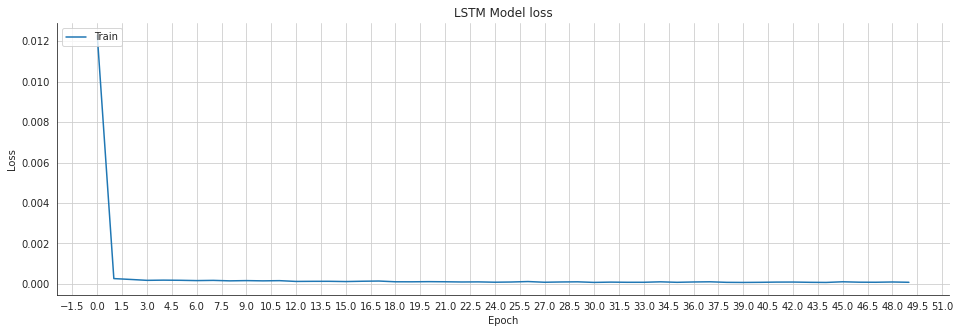

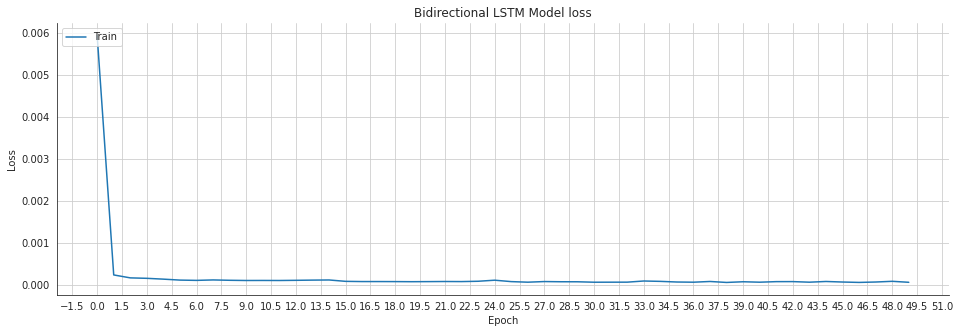

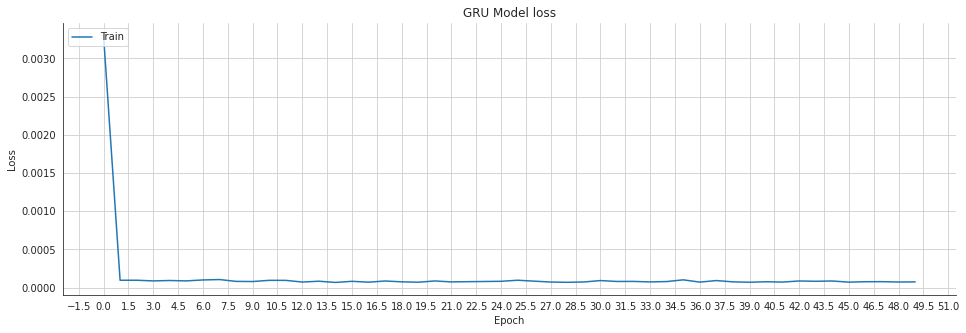

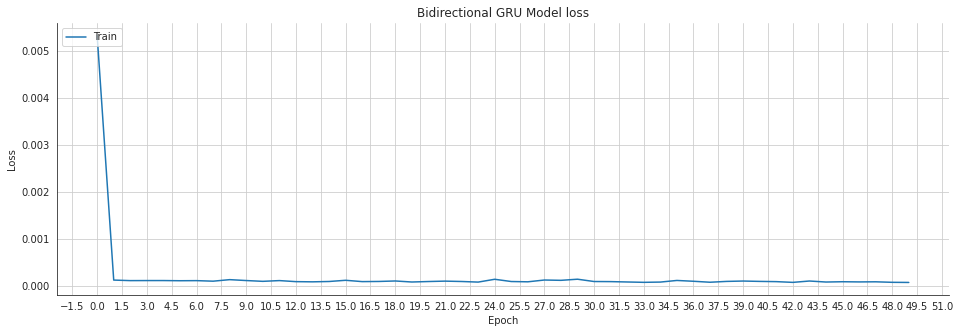

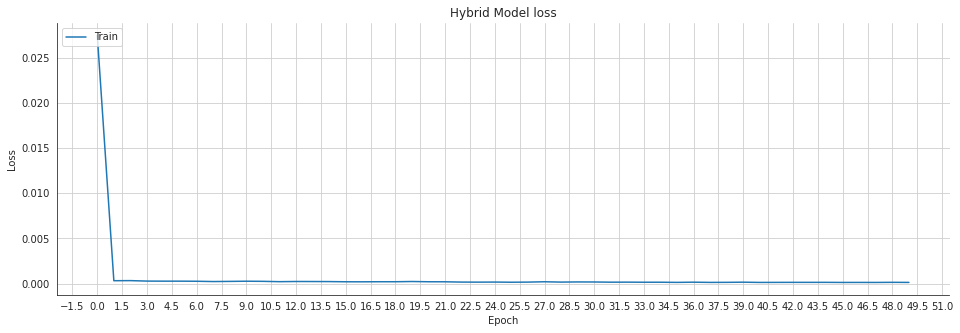

-------------------------------Prediction lstm---------------------------
16/16 [==============================] - 1s 19ms/step
Median Absolute Error (MAE): 132.66
Mean Absolute Percentage Error (MAPE): 0.8 %
Median Absolute Percentage Error (MDAPE): 0.61 %


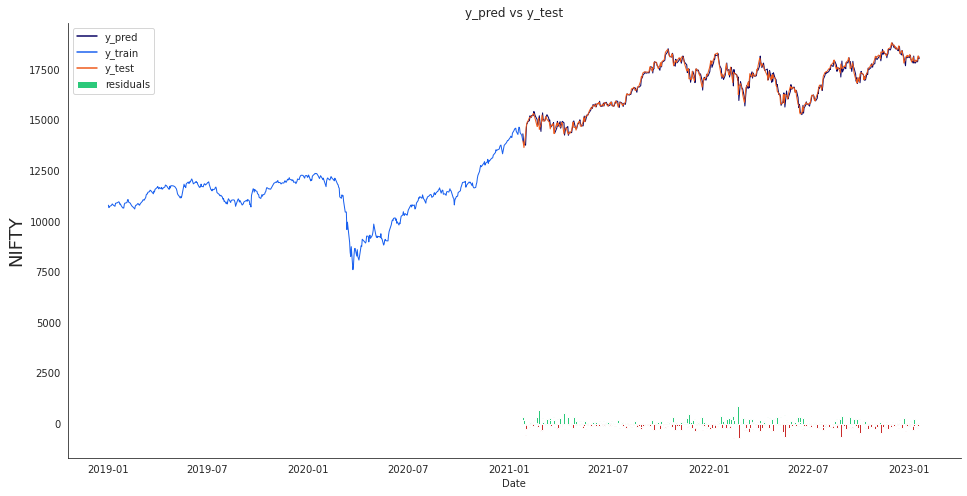

1/1 [==============================] - 0s 33ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 17987.0390625 (-0.23%)
-------------------------------Prediction bi_lstm---------------------------
16/16 [==============================] - 1s 17ms/step
Median Absolute Error (MAE): 145.97
Mean Absolute Percentage Error (MAPE): 0.88 %
Median Absolute Percentage Error (MDAPE): 0.73 %


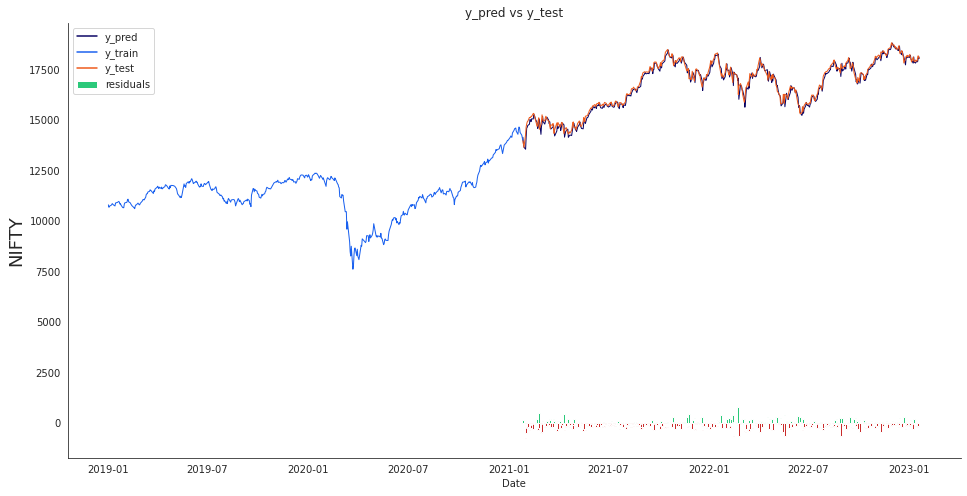

1/1 [==============================] - 0s 20ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 17986.119140625 (-0.23%)
-------------------------------Prediction GRU---------------------------
16/16 [==============================] - 0s 9ms/step
Median Absolute Error (MAE): 360.14
Mean Absolute Percentage Error (MAPE): 2.14 %
Median Absolute Percentage Error (MDAPE): 2.13 %


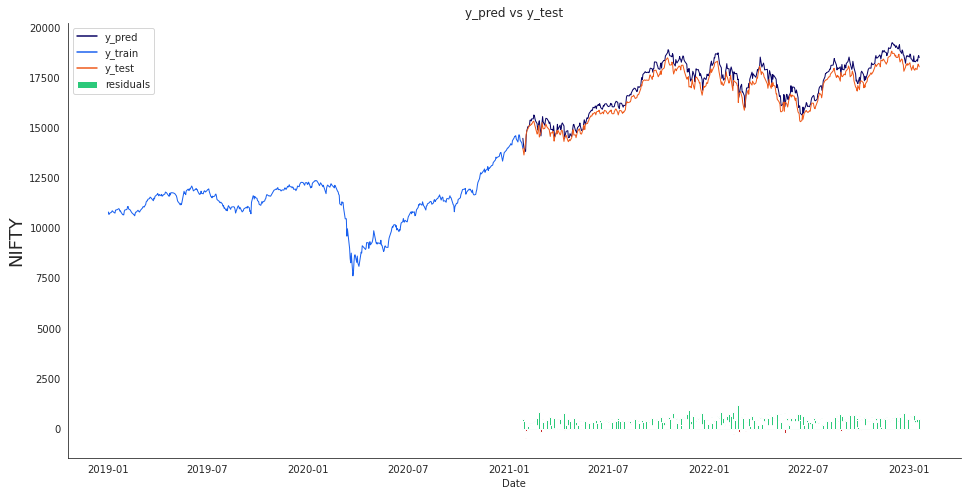

1/1 [==============================] - 0s 19ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 18445.140625 (+2.26%)
-------------------------------Prediction bi_GRU---------------------------
16/16 [==============================] - 1s 15ms/step
Median Absolute Error (MAE): 217.19
Mean Absolute Percentage Error (MAPE): 1.31 %
Median Absolute Percentage Error (MDAPE): 1.22 %


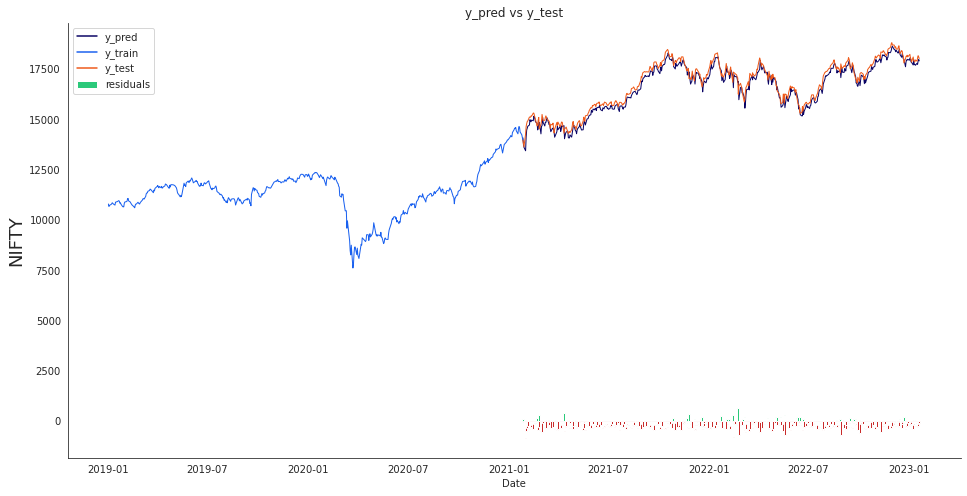

1/1 [==============================] - 0s 23ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 17853.140625 (-0.98%)
-------------------------------Prediction hybrid---------------------------
16/16 [==============================] - 1s 27ms/step
Median Absolute Error (MAE): 131.51
Mean Absolute Percentage Error (MAPE): 0.79 %
Median Absolute Percentage Error (MDAPE): 0.63 %


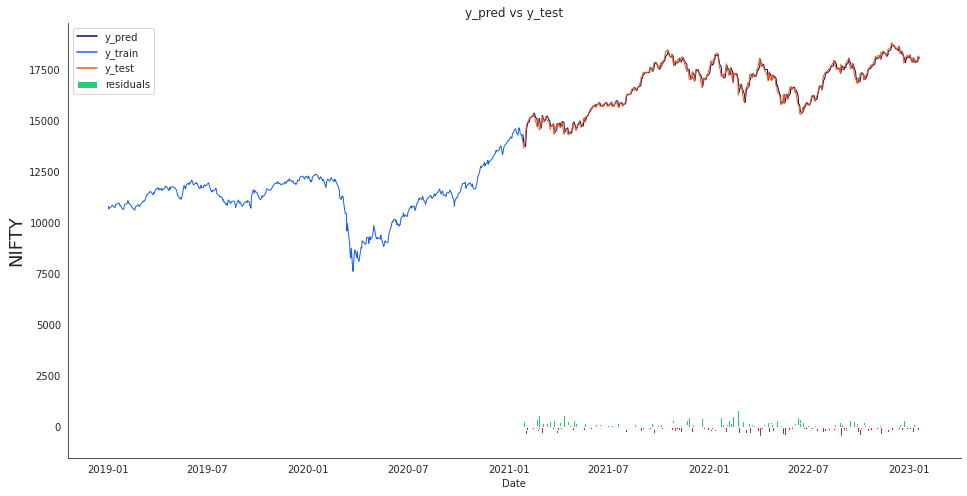

1/1 [==============================] - 0s 27ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 18003.779296875 (-0.13%)


In [ ]:
symbol='^NSEI'
stockname='NIFTY'
stock_training(symbol,stockname)
#adam->optimizer
#mse->loss

[*********************100%***********************]  1 of 1 completed
FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Enter timesteps: 50
(2470, 6)
0 Open
1 High
2 Low
3 Close
4 Adj Close
5 Volume
Enter prediction attribute: close
(1926, 50, 6) (1926,)
(494, 50, 6) (494,)
0.041855494016817596
0.041855494016817596
Enter Optimizer: adam
Enter Loss: mse
Enter number of epochs: 50
300 50 6
300 50 6
300 50 6
300 50 6
300 50 6
-------------------------------Training Start LSTM---------------------------
Epoch 1/50
121/121 [==============================] - 4s 16ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 2/50
121/121 [==============================] - 1s 10ms/step - loss: 1.9958e-04 - val_loss: 0.0010
Epoch 3/50
121/121 [==============================] - 1s 10ms/step - loss: 1.8219e-04 - val_loss: 7.0900e-04
Epoch 4/50
121/121 [==============================] - 1s 10ms/step - loss: 1.8692e-04 - val_loss: 0.0012
Epoch 5/50
121/121 [==============================] - 1s 

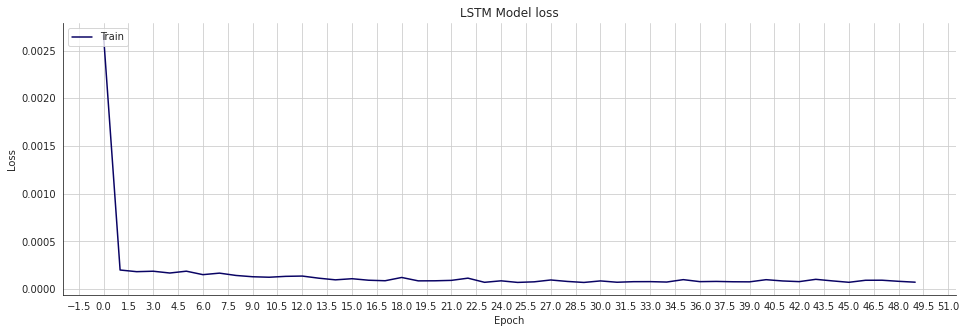

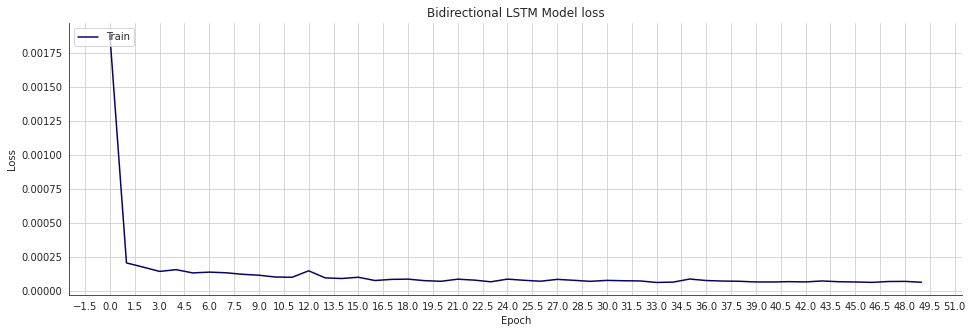

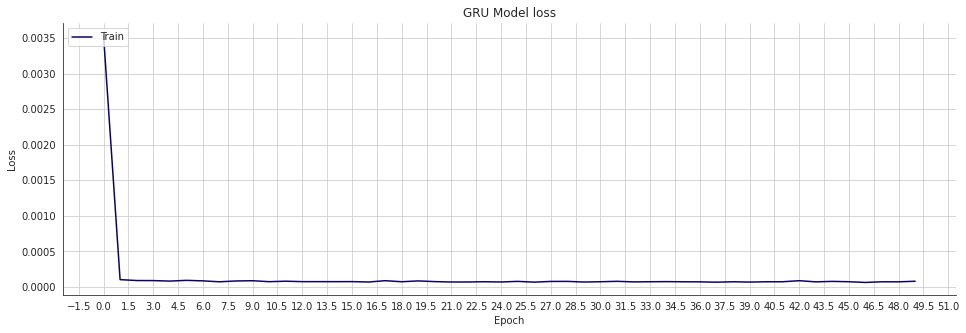

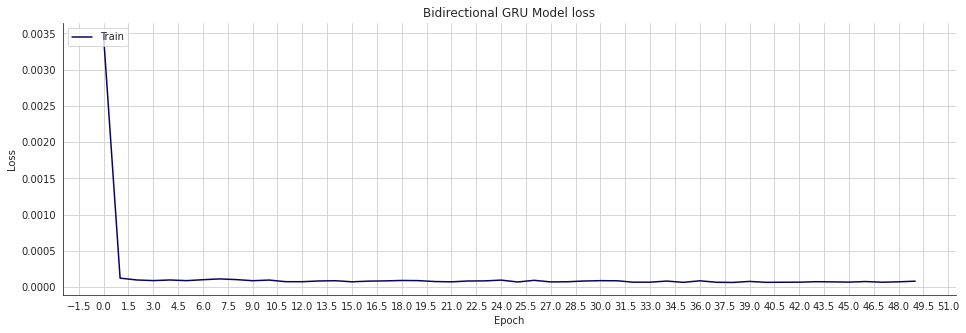

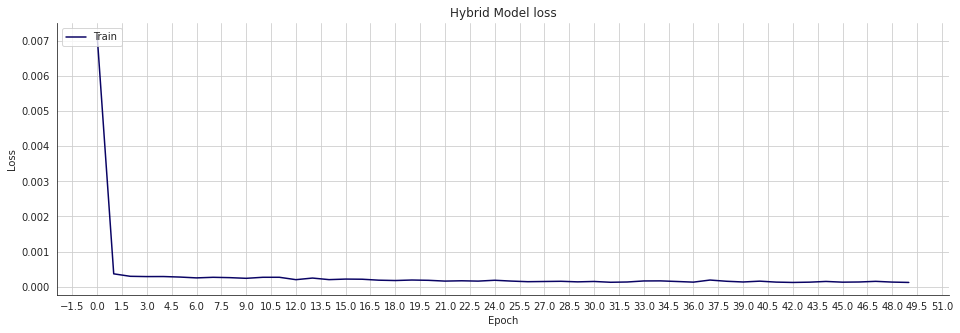

-------------------------------Prediction lstm---------------------------
16/16 [==============================] - 1s 8ms/step
Median Absolute Error (MAE): 136.4
Mean Absolute Percentage Error (MAPE): 0.82 %
Median Absolute Percentage Error (MDAPE): 0.63 %


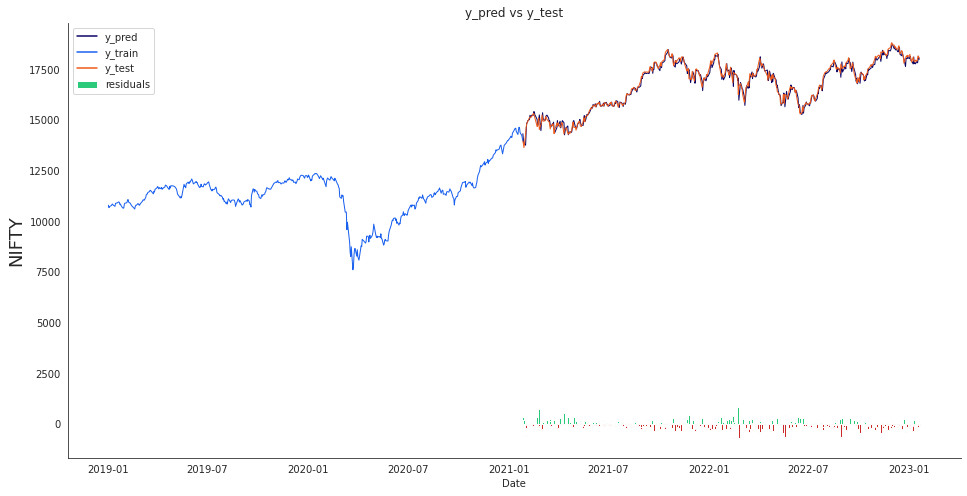

1/1 [==============================] - 0s 21ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 17947.580078125 (-0.45%)
-------------------------------Prediction bi_lstm---------------------------
16/16 [==============================] - 1s 6ms/step
Median Absolute Error (MAE): 129.72
Mean Absolute Percentage Error (MAPE): 0.78 %
Median Absolute Percentage Error (MDAPE): 0.59 %


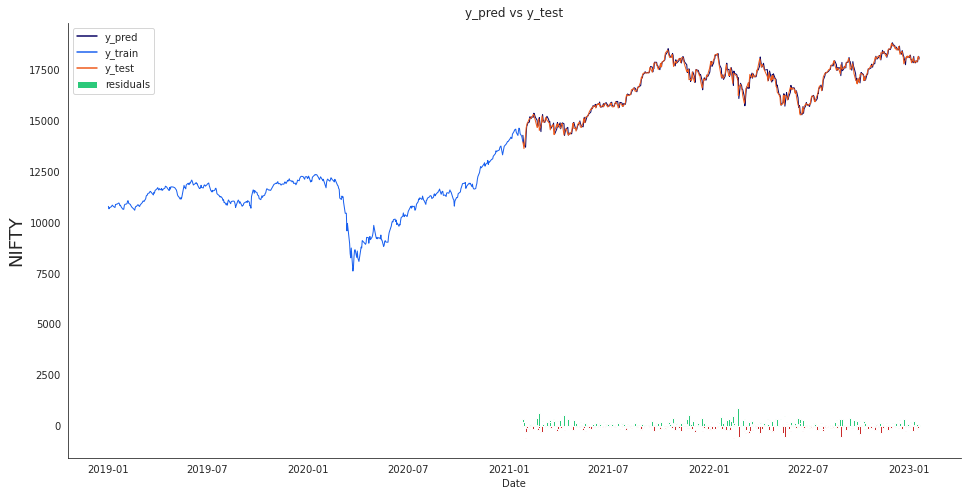

1/1 [==============================] - 0s 22ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 18028.2109375 (0.0%)
-------------------------------Prediction GRU---------------------------
16/16 [==============================] - 0s 4ms/step
Median Absolute Error (MAE): 178.42
Mean Absolute Percentage Error (MAPE): 1.06 %
Median Absolute Percentage Error (MDAPE): 0.96 %


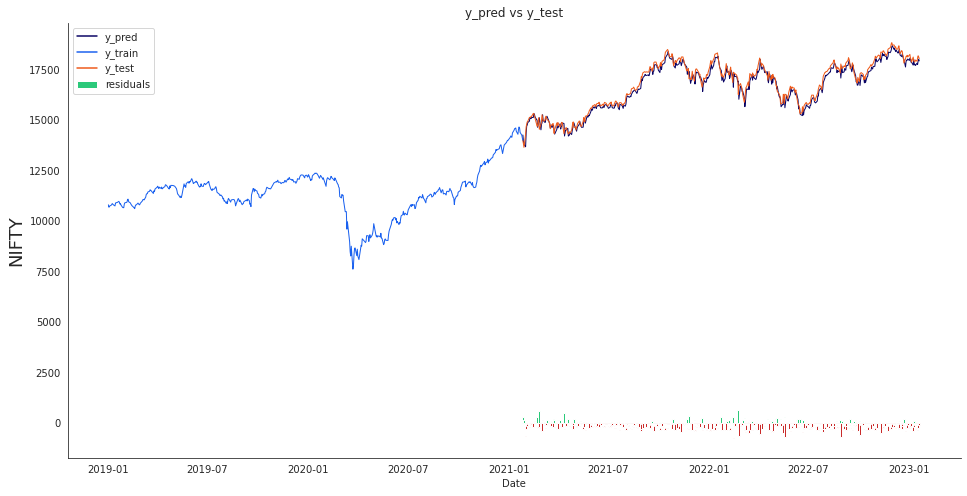

1/1 [==============================] - 0s 16ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 17865.349609375 (-0.91%)
-------------------------------Prediction bi_GRU---------------------------
16/16 [==============================] - 1s 6ms/step
Median Absolute Error (MAE): 172.71
Mean Absolute Percentage Error (MAPE): 1.04 %
Median Absolute Percentage Error (MDAPE): 0.88 %


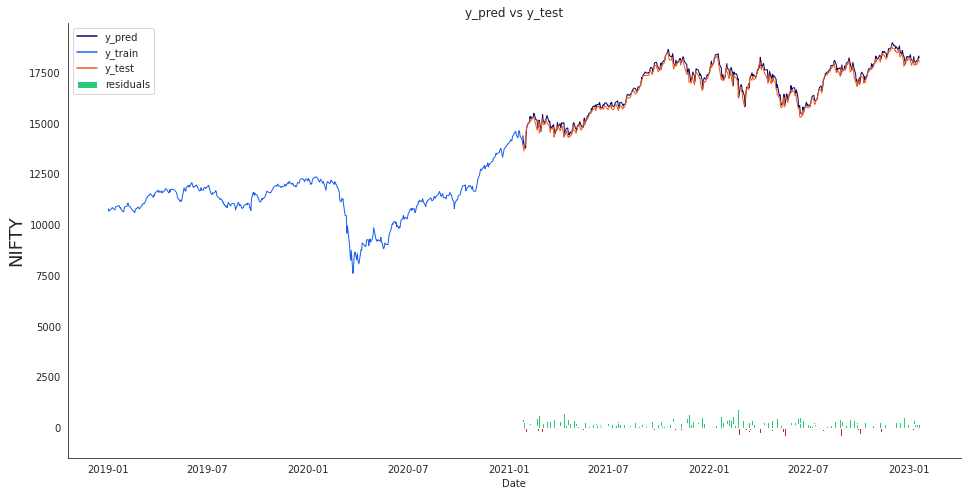

1/1 [==============================] - 0s 18ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 18164.140625 (+0.75%)
-------------------------------Prediction hybrid---------------------------
16/16 [==============================] - 1s 9ms/step
Median Absolute Error (MAE): 164.85
Mean Absolute Percentage Error (MAPE): 0.98 %
Median Absolute Percentage Error (MDAPE): 0.91 %


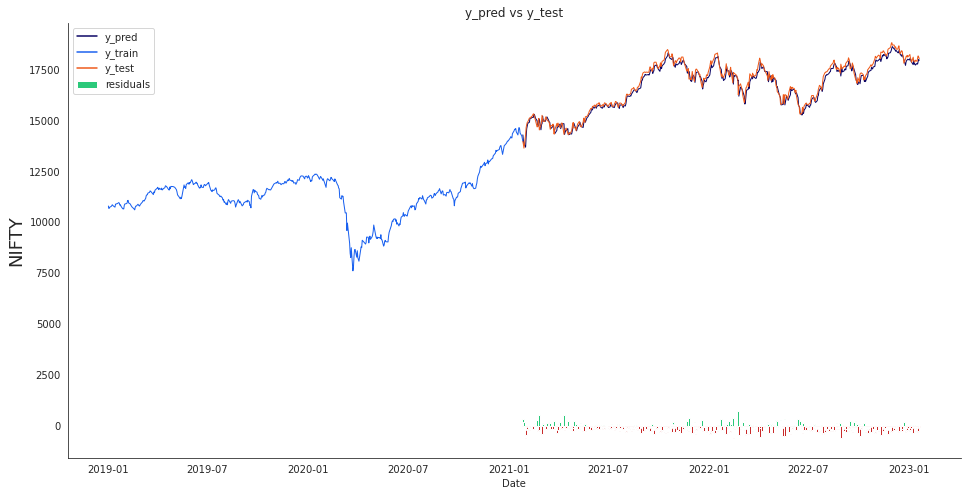

1/1 [==============================] - 0s 19ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 17894.08984375 (-0.75%)


In [ ]:
symbol='^NSEI'
stockname='NIFTY'
stock_training(symbol,stockname)
#steps->50
#attribut->close
#epochs->50
#optimizer->adam
#loss->mse 

[*********************100%***********************]  1 of 1 completed
FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
Enter timesteps: 25
(2470, 6)
0 Open
1 High
2 Low
3 Close
4 Adj Close
5 Volume
Enter prediction attribute: close
(1951, 25, 6) (1951,)
(494, 25, 6) (494,)
0.04983923084919606
0.04983923084919606
Enter Optimizer: adam
Enter Loss: mse
Enter number of epochs: 50
150 25 6
150 25 6
150 25 6
150 25 6
150 25 6
-------------------------------Training Start LSTM---------------------------
Epoch 1/50
122/122 [==============================] - 4s 12ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 2/50
122/122 [==============================] - 1s 8ms/step - loss: 2.3962e-04 - val_loss: 8.2678e-04
Epoch 3/50
122/122 [==============================] - 1s 7ms/step - loss: 2.1032e-04 - val_loss: 7.0193e-04
Epoch 4/50
122/122 [==============================] - 1s 7ms/step - loss: 1.7174e-04 - val_loss: 4.9880e-04
Epoch 5/50
122/122 [==============================] - 

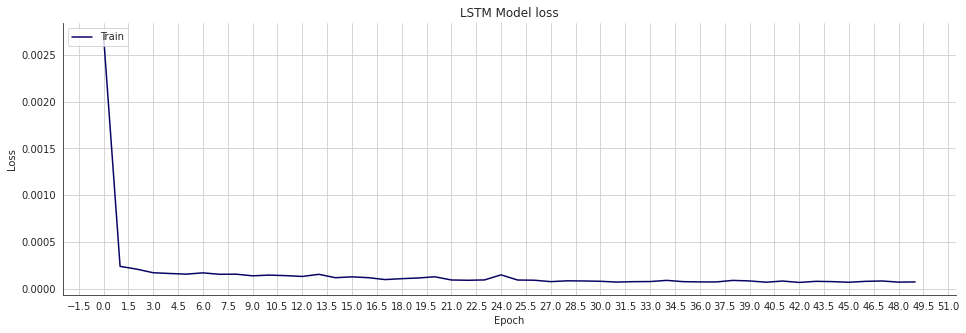

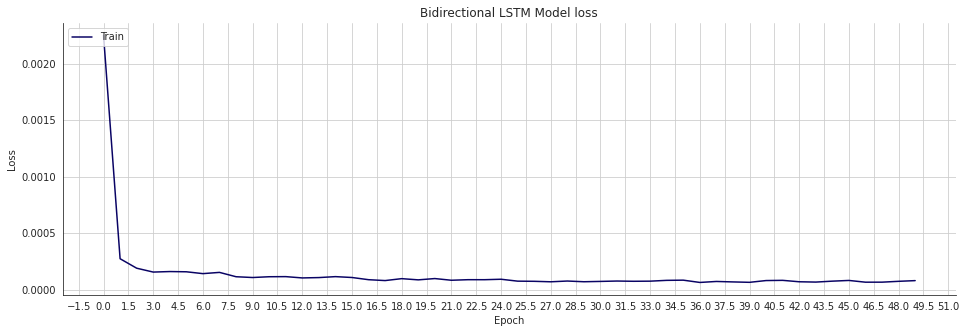

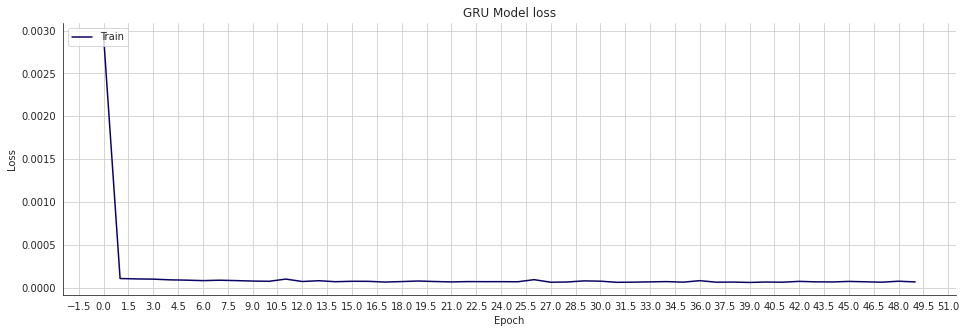

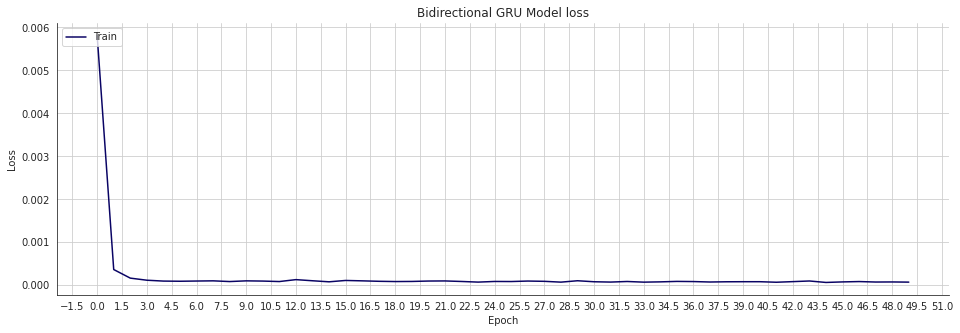

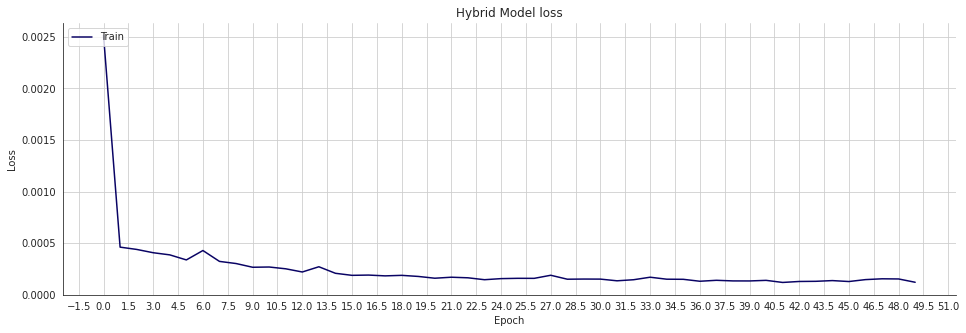

-------------------------------Prediction lstm---------------------------
16/16 [==============================] - 1s 3ms/step
Median Absolute Error (MAE): 266.63
Mean Absolute Percentage Error (MAPE): 1.57 %
Median Absolute Percentage Error (MDAPE): 1.5 %


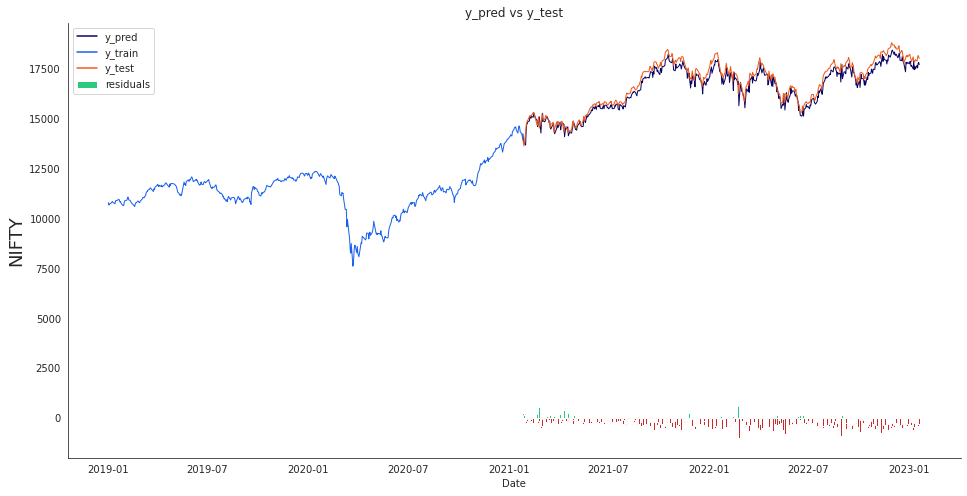

1/1 [==============================] - 0s 21ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 17685.0390625 (-1.94%)
-------------------------------Prediction bi_lstm---------------------------
16/16 [==============================] - 1s 4ms/step
Median Absolute Error (MAE): 130.25
Mean Absolute Percentage Error (MAPE): 0.79 %
Median Absolute Percentage Error (MDAPE): 0.58 %


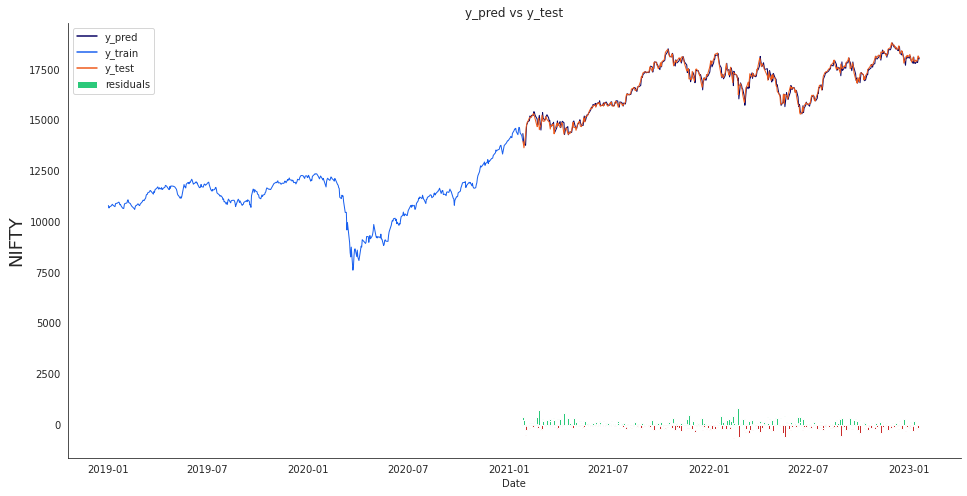

1/1 [==============================] - 0s 16ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 17966.130859375 (-0.34%)
-------------------------------Prediction GRU---------------------------
16/16 [==============================] - 0s 2ms/step
Median Absolute Error (MAE): 162.87
Mean Absolute Percentage Error (MAPE): 0.98 %
Median Absolute Percentage Error (MDAPE): 0.82 %


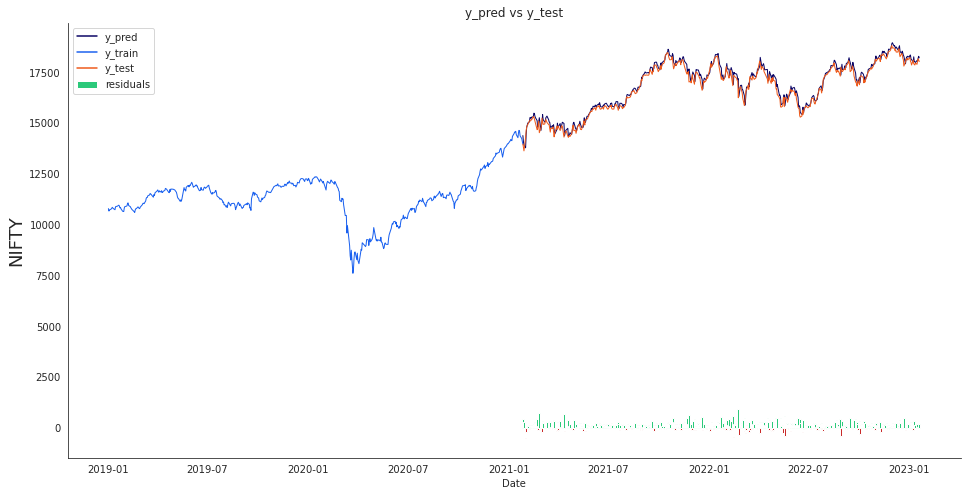

1/1 [==============================] - 0s 17ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 18158.08984375 (+0.72%)
-------------------------------Prediction bi_GRU---------------------------
16/16 [==============================] - 1s 4ms/step
Median Absolute Error (MAE): 309.69
Mean Absolute Percentage Error (MAPE): 1.84 %
Median Absolute Percentage Error (MDAPE): 1.79 %


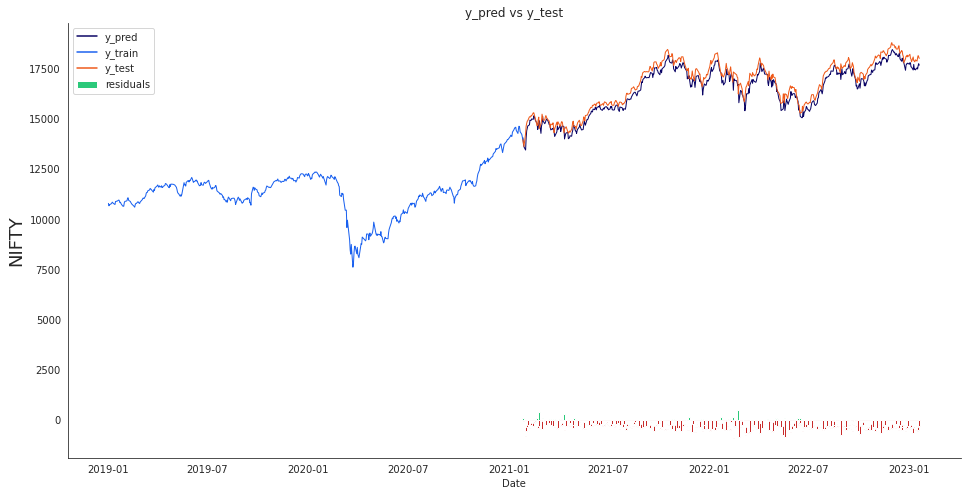

1/1 [==============================] - 0s 16ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 17650.529296875 (-2.14%)
-------------------------------Prediction hybrid---------------------------
16/16 [==============================] - 1s 5ms/step
Median Absolute Error (MAE): 208.54
Mean Absolute Percentage Error (MAPE): 1.26 %
Median Absolute Percentage Error (MDAPE): 1.15 %


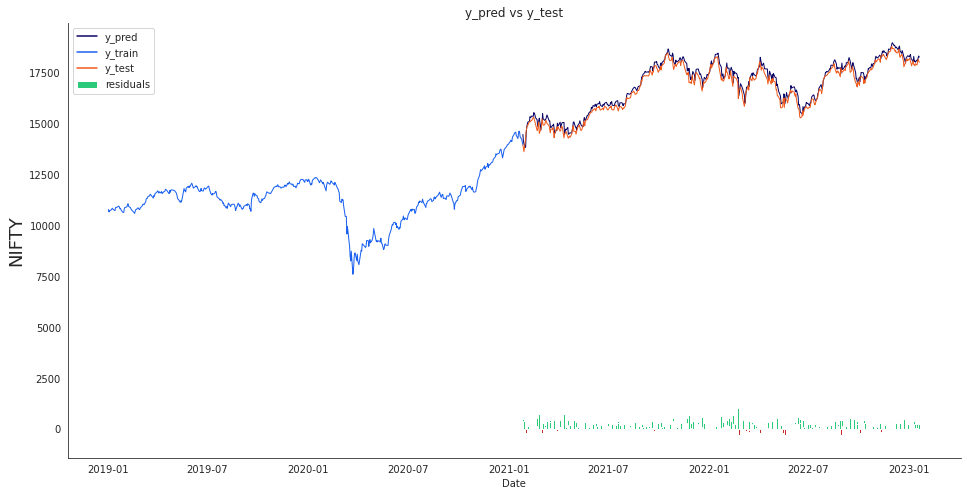

1/1 [==============================] - 0s 19ms/step
The Close price for NIFTY at 2023-01-21 was 18027.65
The predicted Close price is 18221.0 (+1.06%)


In [ ]:
symbol='^NSEI'
stockname='NIFTY'
stock_training(symbol,stockname)
#steps->25
#attribut->close
#epochs->50
#optimizer->adam
#loss->mse 